<a href="https://colab.research.google.com/github/alinespereira/alshenawy-distribution/blob/main/Alshenawy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext rich

In [2]:
# from pathlib import Path

# for path in [
#     Path("./img/classical/sim"),
#     Path("./img/classical/application"),
#     Path("./res/classical/sim"),
#     Path("./res/classical/application"),

#     Path("./img/bayesian/sim/uninformative"),
#     Path("./img/bayesian/sim/informative"),
#     Path("./img/bayesian/application/uninformative"),
#     Path("./img/bayesian/application/informative"),

#     Path("./res/bayesian/sim/uninformative"),
#     Path("./res/bayesian/sim/informative"),
#     Path("./res/bayesian/application/uninformative"),
#     Path("./res/bayesian/application/informative"),
# ]:
#     try:
#         path.mkdir(mode=0o755, parents=True)
#     except FileExistsError:
#         pass

In [3]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
from scipy import stats, optimize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from distributions.rv import a
from distributions.continuous import A
from stats import classical, bayesian
from stats.utils import summarize

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
plt.style.use("arviz-darkgrid")

# Estudo de simulação

In [5]:
REPLICATIONS: int = 10
SAMPLE_SIZES: list[int] = [25, 50, 100, 200, 400]
BETAS: list[float] = [0.125, 0.6, 1.0]
ALPHA: float = 0.05

In [6]:
RANDOM_SEED: int = 42
RNG: np.random.Generator = np.random.default_rng(RANDOM_SEED)

# Estudo de simulação clássico

In [7]:
%%time
simulations = {}
np.random.seed(RANDOM_SEED)

for beta in BETAS:
    simulations[beta] = {}
    rv = a(beta=beta)
    print(f"{beta = }")
    for n in SAMPLE_SIZES:
        simulations[beta][n] = []
        print(f"\t{n = }")
        for i in tqdm(range(REPLICATIONS)):
            sample = rv.rvs(size=n)
            negative_log_likelihood = lambda beta_: -a(beta=beta_[0]).logpdf(sample).sum()
            simulation = classical.simulate(
                param=beta,
                negative_log_likelihood=negative_log_likelihood,
                initial_guess=0.05,
                sample_size=len(sample),
                alpha=ALPHA,
                method='L-BFGS-B',
                options={'gtol': 1e-6}
            )
            simulations[beta][n].append(simulation)

beta = 0.125
	n = 25


100%|███████████████████████████| 10/10 [00:00<00:00, 32.11it/s]


	n = 50


100%|███████████████████████████| 10/10 [00:00<00:00, 41.57it/s]


	n = 100


100%|███████████████████████████| 10/10 [00:00<00:00, 42.85it/s]


	n = 200


100%|███████████████████████████| 10/10 [00:00<00:00, 41.26it/s]


	n = 400


100%|███████████████████████████| 10/10 [00:00<00:00, 49.57it/s]


beta = 0.6
	n = 25


100%|███████████████████████████| 10/10 [00:00<00:00, 51.22it/s]


	n = 50


100%|███████████████████████████| 10/10 [00:00<00:00, 51.89it/s]


	n = 100


100%|███████████████████████████| 10/10 [00:00<00:00, 53.46it/s]


	n = 200


100%|███████████████████████████| 10/10 [00:00<00:00, 47.06it/s]


	n = 400


100%|███████████████████████████| 10/10 [00:00<00:00, 23.55it/s]


beta = 1.0
	n = 25


100%|███████████████████████████| 10/10 [00:00<00:00, 32.59it/s]


	n = 50


100%|███████████████████████████| 10/10 [00:00<00:00, 47.60it/s]


	n = 100


100%|███████████████████████████| 10/10 [00:00<00:00, 50.44it/s]


	n = 200


100%|███████████████████████████| 10/10 [00:00<00:00, 48.36it/s]


	n = 400


100%|███████████████████████████| 10/10 [00:00<00:00, 41.15it/s]

CPU times: user 3.06 s, sys: 237 ms, total: 3.3 s
Wall time: 3.75 s


In [8]:
summaries = pd.DataFrame([
    summarize(simulations[beta][n])
    for beta in simulations
    for n in simulations[beta]
])

In [9]:
summaries.to_csv("res/classical/sim/summaries.csv", index=False)
summaries

,true_param,sample_size,mean,bias,mse,coverage_probability
0,0.125,25,0.147497,0.022497,0.012182,0.7
1,0.125,50,0.182547,0.057547,0.013075,0.3
2,0.125,100,0.152540,0.027540,0.005729,0.2
3,0.125,200,0.117481,-0.007519,0.002004,0.4
4,0.125,400,0.134984,0.009984,0.000918,0.3
5,0.600,25,0.631509,0.031509,0.082754,0.1
6,0.600,50,0.613966,0.013966,0.020296,0.1
7,0.600,100,0.624734,0.024734,0.009120,0.1
8,0.600,200,0.615987,0.015987,0.005643,0.1
9,0.600,400,0.594347,-0.005653,0.002243,0.1


In [10]:
simulation_results = pd.DataFrame([
    simulation
    for beta in simulations
    for n in simulations[beta]
    for simulation in simulations[beta][n]
])
ci = (
    pd.json_normalize(simulation_results["ci"])
    .rename(columns=lambda col: f"ci_{col}")
)
simulation_results[ci.columns] = ci
simulation_results = simulation_results.drop("ci", axis=1)
simulation_results.to_csv("res/classical/sim/simulations.csv", index=False)
simulation_results

,sample_size,true_param,estimated_param,ci_lower,ci_upper
0,25,0.125,0.174616,0.109190,0.240043
1,25,0.125,0.138236,0.072836,0.203636
2,25,0.125,0.050000,-0.341993,0.441993
3,25,0.125,0.150530,0.084145,0.216916
4,25,0.125,0.214025,0.142207,0.285843
...,...,...,...,...,...
145,400,1.000,0.950351,0.943662,0.957039
146,400,1.000,0.914007,0.907454,0.920560
147,400,1.000,1.028413,1.021474,1.035352
148,400,1.000,1.018687,1.011809,1.025565


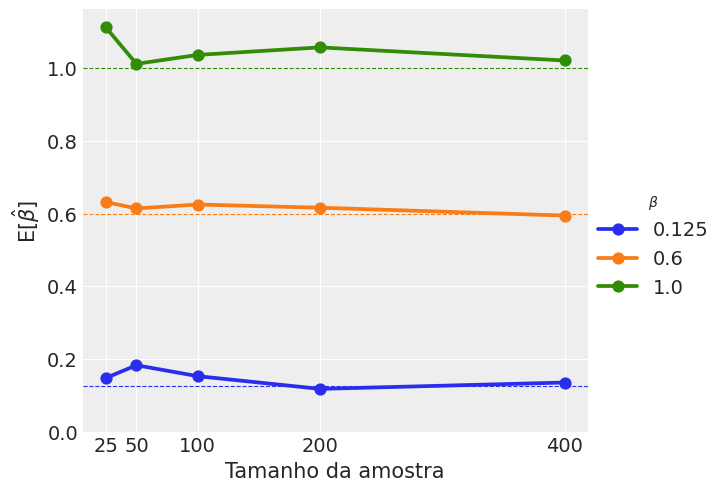

In [11]:
fig, ax = plt.subplots()

sns.pointplot(data=summaries, 
              x="sample_size", 
              y="mean", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(r"$\operatorname{E}[\hat{\beta}]$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

for label, color in zip(labels, sns.color_palette()):
    ax.axhline(float(label), color=color, linestyle="--", linewidth=0.8)

fig.savefig("img/classical/sim/mean.png")

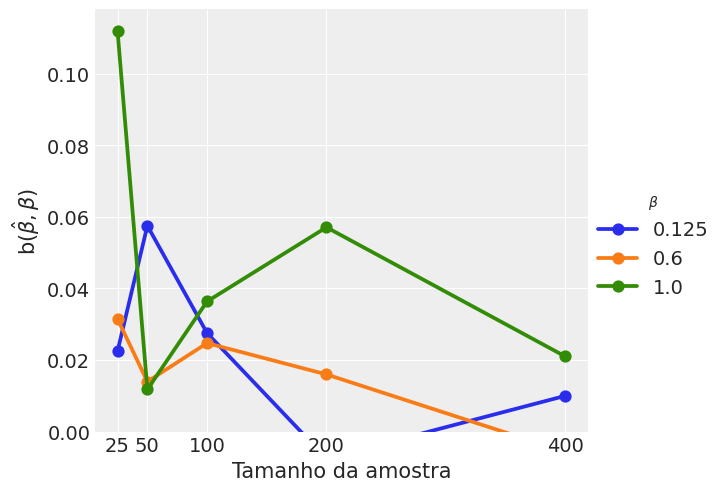

In [12]:
fig, ax = plt.subplots()

sns.pointplot(data=summaries, 
              x="sample_size", 
              y="bias", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(r"$\operatorname{b}(\hat{\beta}, \beta)$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

fig.savefig("img/classical/sim/bias.png")

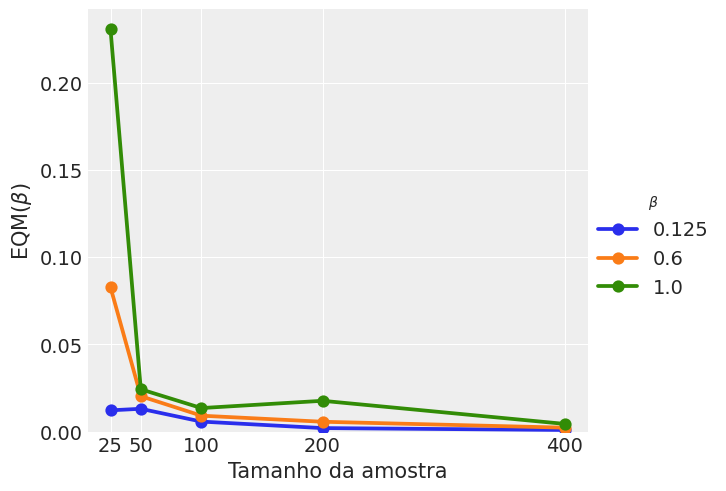

In [13]:
fig, ax = plt.subplots()

sns.pointplot(data=summaries, 
              x="sample_size", 
              y="mse", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(r"$\operatorname{EQM}(\beta)$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

fig.savefig("img/classical/sim/eqm.png")

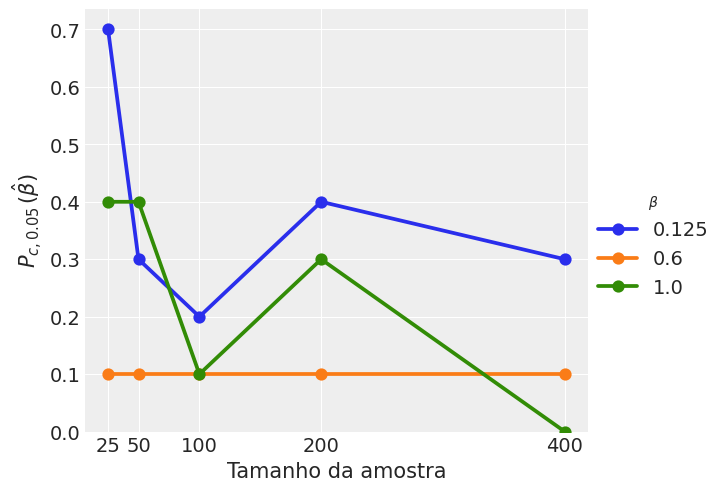

In [14]:
fig, ax = plt.subplots()

sns.pointplot(data=summaries, 
              x="sample_size", 
              y="coverage_probability", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(f"$\\operatorname{{P_{{c, {ALPHA:.2f}}}}}(\\hat{{\\beta}})$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

ax.axhline(1 - ALPHA, color="dimgrey", linestyle="--", linewidth=0.8)

fig.savefig("img/classical/sim/pc.png")

# Estudo de simulação bayesiano

## Priori $\operatorname{Gama}(0.01, 0.001)$

\begin{align*}
    \beta &\sim \operatorname{Gama}(0.01, 0.001) \\
    X &\sim \operatorname{A}(\beta)
\end{align*}

In [17]:
%%time
uninformative_simulations = {}

for beta in BETAS:
    uninformative_simulations[beta] = {}
    rv = a(beta=beta)
    print(f"{beta = }")
    for n in SAMPLE_SIZES:
        uninformative_simulations[beta][n] = []
        print(f"\t{n = }")
        model = bayesian.make_model(
            sample = rv.rvs(size=n),
            prior=pm.Gamma,
            prior_params={"name": "beta", "alpha": 1, "beta": 1},
        )
        for i in tqdm(range(REPLICATIONS)):
            sample = rv.rvs(size=n)
            simulation = bayesian.simulate(
                param=beta,
                sample=sample,
                model=model,
                alpha=.05,
                sampler_params={
                    "draws": 1000,
                    "chains": 2,
                    "tune": 1000,
                    "target_accept": .99,
                    "random_seed": RNG,
                    "cores": 2,
                    "nuts_sampler": "numpyro",
                    "progressbar": False
                }
            )
            uninformative_simulations[beta][n].append(simulation)

beta = 0.125
	n = 25


100%|███████████████████████████| 10/10 [00:34<00:00,  3.43s/it]


	n = 50


100%|███████████████████████████| 10/10 [00:36<00:00,  3.61s/it]


	n = 100


100%|███████████████████████████| 10/10 [00:41<00:00,  4.20s/it]


	n = 200


100%|███████████████████████████| 10/10 [00:39<00:00,  3.96s/it]


	n = 400


100%|███████████████████████████| 10/10 [00:43<00:00,  4.40s/it]


beta = 0.6
	n = 25


100%|███████████████████████████| 10/10 [00:36<00:00,  3.60s/it]


	n = 50


100%|███████████████████████████| 10/10 [00:35<00:00,  3.53s/it]


	n = 100


100%|███████████████████████████| 10/10 [00:38<00:00,  3.86s/it]


	n = 200


100%|███████████████████████████| 10/10 [00:38<00:00,  3.81s/it]


	n = 400


100%|███████████████████████████| 10/10 [00:40<00:00,  4.00s/it]


beta = 1.0
	n = 25


100%|███████████████████████████| 10/10 [00:36<00:00,  3.61s/it]


	n = 50


100%|███████████████████████████| 10/10 [00:36<00:00,  3.68s/it]


	n = 100


100%|███████████████████████████| 10/10 [00:42<00:00,  4.26s/it]


	n = 200


100%|███████████████████████████| 10/10 [00:38<00:00,  3.85s/it]


	n = 400


100%|███████████████████████████| 10/10 [00:38<00:00,  3.81s/it]

CPU times: user 13min 21s, sys: 36.4 s, total: 13min 58s
Wall time: 9min 36s


In [18]:
uninformative_summaries = pd.DataFrame([
    summarize(uninformative_simulations[beta][n])
    for beta in uninformative_simulations
    for n in uninformative_simulations[beta]
])

In [19]:
uninformative_summaries.to_csv("res/bayesian/sim/uninformative/summaries.csv", index=False)
uninformative_summaries

,true_param,sample_size,mean,bias,mse,coverage_probability
0,0.125,25,0.280604,0.155604,0.064485,0.8
1,0.125,50,0.229961,0.104961,0.019470,0.9
2,0.125,100,0.137217,0.012217,0.001725,0.9
3,0.125,200,0.132202,0.007202,0.003769,0.9
4,0.125,400,0.145447,0.020447,0.001744,1.0
5,0.600,25,0.635319,0.035319,0.067454,0.9
6,0.600,50,0.586425,-0.013575,0.032953,1.0
7,0.600,100,0.590352,-0.009648,0.020423,0.8
8,0.600,200,0.591546,-0.008454,0.005843,1.0
9,0.600,400,0.582420,-0.017580,0.001882,1.0


In [20]:
simulation_results = pd.DataFrame([
    simulation
    for beta in uninformative_simulations
    for n in uninformative_simulations[beta]
    for simulation in uninformative_simulations[beta][n]
])
ci = (
    pd.json_normalize(simulation_results["ci"])
    .rename(columns=lambda col: f"ci_{col}")
)
simulation_results[ci.columns] = ci
simulation_results = simulation_results.drop("ci", axis=1)
simulation_results.to_csv("res/bayesian/sim/uninformative/simulations.csv", index=False)
simulation_results

,sample_size,true_param,estimated_param,ci_lower,ci_upper
0,25,0.125,0.430814,0.038798,0.785342
1,25,0.125,0.043431,0.000026,0.116329
2,25,0.125,0.282868,0.000060,0.563382
3,25,0.125,0.482493,0.049526,0.849385
4,25,0.125,0.192272,0.000374,0.419609
...,...,...,...,...,...
145,400,1.000,0.964613,0.842944,1.101492
146,400,1.000,0.955444,0.825278,1.106728
147,400,1.000,1.079770,0.932524,1.210750
148,400,1.000,0.846241,0.722787,0.964164


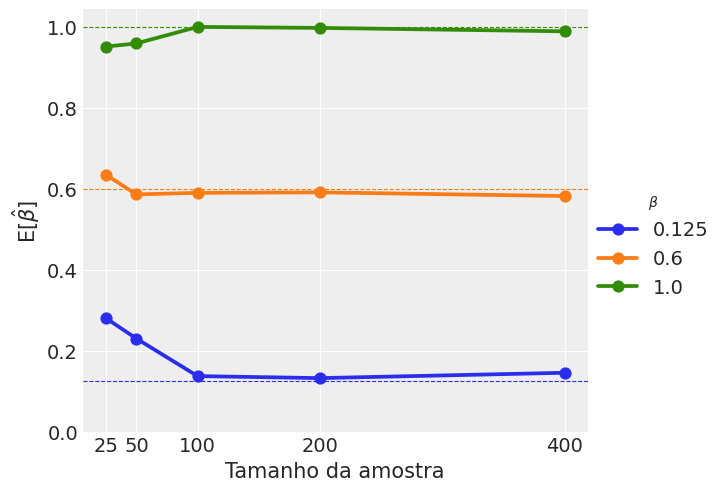

In [21]:
fig, ax = plt.subplots()

sns.pointplot(data=uninformative_summaries, 
              x="sample_size", 
              y="mean", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(r"$\operatorname{E}[\hat{\beta}]$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

for label, color in zip(labels, sns.color_palette()):
    ax.axhline(float(label), color=color, linestyle="--", linewidth=0.8)

fig.savefig("img/bayesian/sim/uninformative/mean.png")

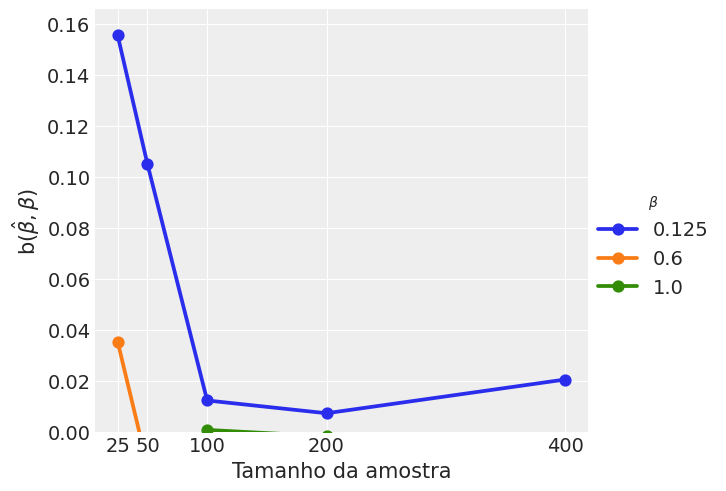

In [22]:
fig, ax = plt.subplots()

sns.pointplot(data=uninformative_summaries,
              x="sample_size", 
              y="bias", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(r"$\operatorname{b}(\hat{\beta}, \beta)$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

fig.savefig("img/bayesian/sim/uninformative/bias.png")

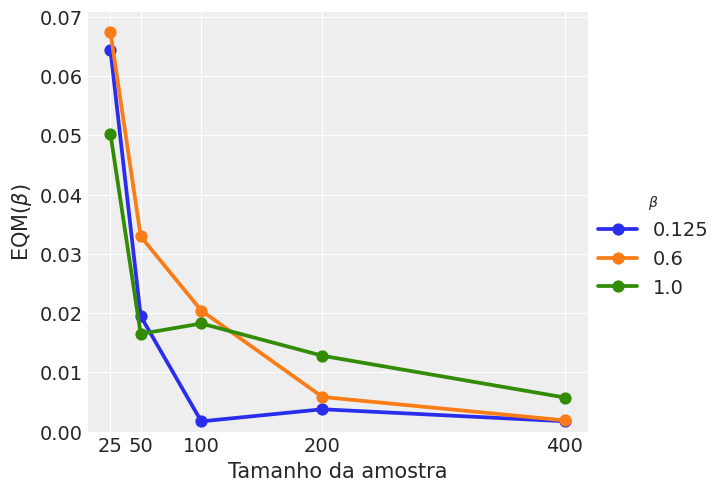

In [23]:
fig, ax = plt.subplots()

sns.pointplot(data=uninformative_summaries, 
              x="sample_size", 
              y="mse", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(r"$\operatorname{EQM}(\beta)$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

fig.savefig("img/bayesian/sim/uninformative/eqm.png")

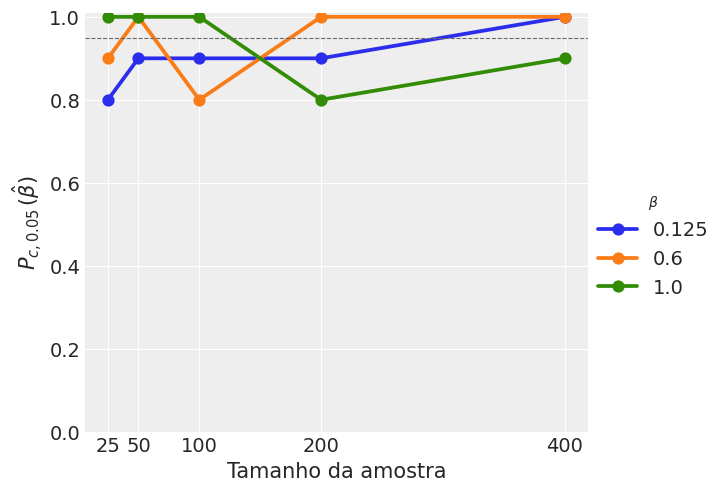

In [24]:
fig, ax = plt.subplots()

sns.pointplot(data=uninformative_summaries, 
              x="sample_size", 
              y="coverage_probability", 
              hue="true_param",
              palette=sns.color_palette()[:len(BETAS)],
              native_scale=True,
              ax=ax)

ax.set_xticks(SAMPLE_SIZES)
ax.set_xticklabels(SAMPLE_SIZES)

ax.set_xlabel("Tamanho da amostra")
ax.set_ylabel(f"$\\operatorname{{P_{{c, {ALPHA:.2f}}}}}(\\hat{{\\beta}})$")

_, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)

handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, labels, loc="outside center right", title=r"$\beta$")

ax.axhline(1 - ALPHA, color="dimgrey", linestyle="--", linewidth=0.8)

fig.savefig("img/bayesian/sim/uninformative/pc.png")